# Hard spheres model development


First stage: Develop a CNN - based GAN to work with ordered point clouds.

## Imports

In [7]:
%reload_ext autoreload
%autoreload 2

In [8]:
# Basic
from IPython.display import display

# For OS-agnostic paths
from pathlib import Path

# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from torch import nn
import pandas as pd
import numpy as np
sns.set_style("whitegrid")
from copy import deepcopy
import glob, json
from datetime import datetime
import torch
from torch import nn

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import DataLoader, Dataset, TensorDataset


from torchinfo import summary

import mlflow

%cd ..

from src.utils import load_raw_data
from src.plotting import plot_pointcloud, plot_sample_figures

%cd -

/Users/veikko/Documents/GitHub/hard-spheres
/Users/veikko/Documents/GitHub/hard-spheres/Notebooks


/Users/veikko/Documents/GitHub/hard-spheres/.venv/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Load data

In [9]:

phis = [0.84, 0.74] # Add more phis here
path = Path("../data/raw/samples")

files, dataframe, metadata = load_raw_data(path, phi=phis)

dataframe

Number of Files found :  900


class          x          y         r
experiment sample                                           
phi-0.84   sample-245     12  17.442748 -17.081946  1.245263
           sample-245      1  14.625251  14.245529  0.730000
           sample-245      3 -19.113390  20.579243  0.823684
           sample-245      3 -17.980250 -10.332299  0.823684
           sample-245     11 -12.854737 -11.140054  1.198421
...                      ...        ...        ...       ...
phi-0.74   sample-201     13   1.560774  -9.533826  1.292105
           sample-201      1   4.417034 -13.831392  0.730000
           sample-201      1   7.749583  17.967815  0.730000
           sample-201      1 -10.482027  -0.638836  0.730000
           sample-201      1  17.057946  -4.977512  0.730000

[1800000 rows x 4 columns]

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

dataframe_scaled = pd.DataFrame(scaler.fit_transform(dataframe), columns=dataframe.columns)

dataframe_scaled.set_index(dataframe.index, inplace=True)

dataframe_scaled = dataframe_scaled.drop(columns=["class"]) # Redundant with r

### IMPORTANT: Order dataframe based on Xy coordinates

This is done to introduce the spatial relationship that a CNN can utilize.


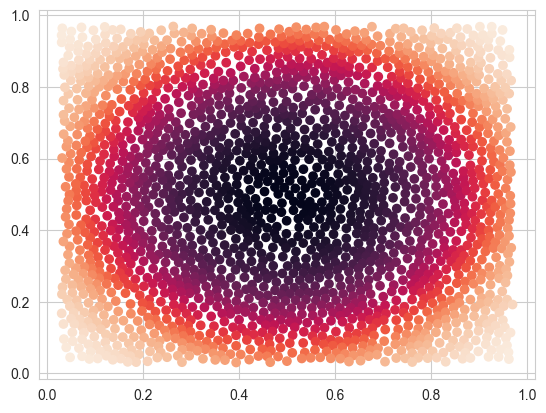

In [11]:
_X = dataframe_scaled.copy()
_X["Xy"] = _X["x"] + _X["y"] # Think about starting from center and going radially outwards


_X["Xy"] = np.sqrt(((_X["x"]-0.5)**2) + ((_X["y"]-0.5)**2))

_X = _X.query("experiment=='phi-0.84'&sample=='sample-1'")

_X = _X.sort_values(by=["Xy", "x", "y"])

_X = _X.reset_index(drop=True)

_X

plt.scatter(x=_X.values[:,0], y=_X.values[:,1], c=_X.index)


This is better than not ordered, but can be problematic as values in the middle have a high probability of ending up with non-neighbouring samples.

However it is also a good experiment as if we observe that the corners behave better than the middle, we know we are on to something.

In [12]:
dataframe_scaled_ordered = dataframe_scaled.copy()
dataframe_scaled_ordered["Xy"] = np.sqrt(((dataframe_scaled_ordered["x"]-0.5)**2) + ((dataframe_scaled_ordered["y"]-0.5)**2))
dataframe_scaled_ordered = dataframe_scaled_ordered.sort_values(by=["experiment", "sample", "Xy"])
dataframe_scaled_ordered = dataframe_scaled_ordered.drop(columns=["Xy"])

## Build dataset

In [13]:
from src.HSDataset import HSDataset

dataset = HSDataset(dataframe_scaled_ordered, descriptor_list=["phi"])

Creating Dataset
Descriptor List:  ['phi']


In [71]:
print(dataset[:][0].shape)
print(dataset[:][1].shape)

torch.Size([900, 1, 3])
torch.Size([900, 2000, 3])


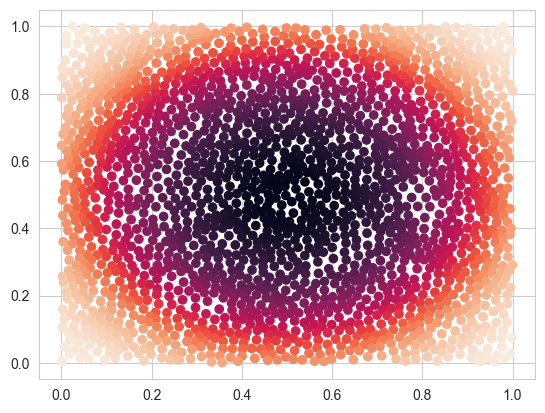

In [72]:
plt.scatter(x=dataset[2][1][:,0], y=dataset[2][1][:,1], c=list(range(len(dataset[2][1]))))


<Axes: >

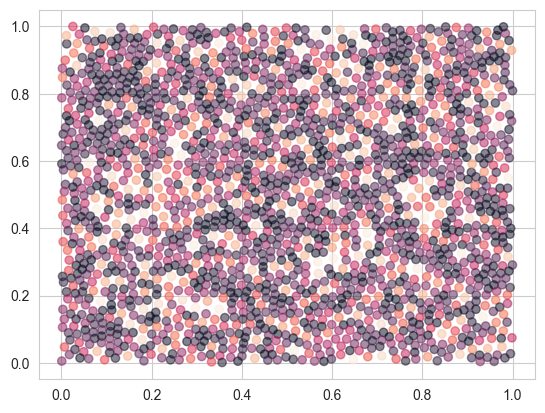

In [73]:
# Create a function that visualizes the point cloud

plot_pointcloud(dataset[2][1], plot_radius=False)

## Note: Samples are order invariant in the sample size dimension

<Axes: >

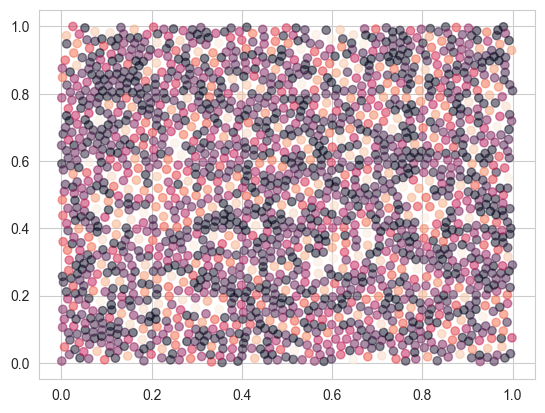

In [74]:
plot_pointcloud(reversed(dataset[2][1]), plot_radius=False)


## Check on x, y, r distributions

<Axes: xlabel='r', ylabel='Count'>

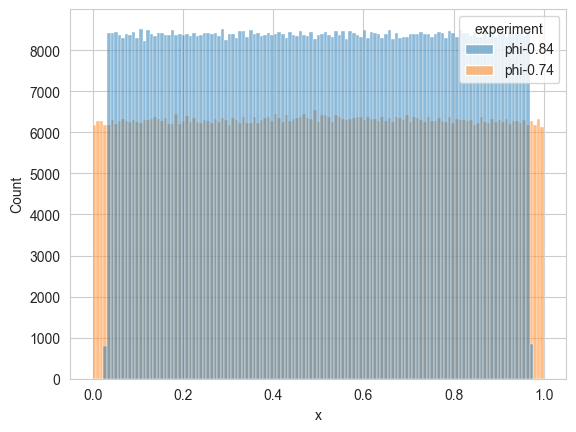

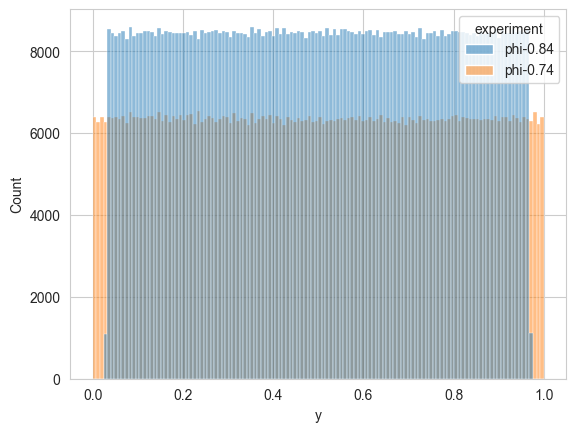

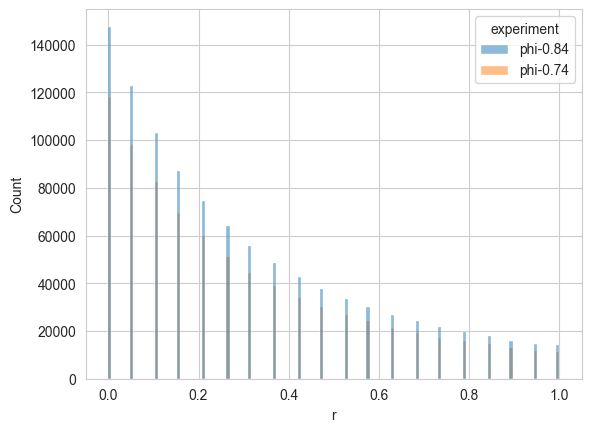

In [75]:
plt.figure()
sns.histplot(dataframe_scaled, x="x", hue="experiment", bins="auto")
plt.figure()
sns.histplot(dataframe_scaled, x="y", hue="experiment", bins="auto")
plt.figure()
sns.histplot(dataframe_scaled, x="r", hue="experiment", bins="auto")

x, y are uniform distributions

r seems to be an 1/x

# Create model

Create a GAN architecture, which creates point clouds $\hat{y}$ based on the descriptor(s) $\hat{X}$ and a random noise vector $\hat{z}$.

In [17]:
sample_x = dataset[0:32][0]#.transpose(-1,-2)
sample_y = dataset[0:32][1]

print(sample_x.shape, sample_y.shape)

torch.Size([32, 1, 3]) torch.Size([32, 2000, 3])


## Play around with models

(array([48., 30.,  9.,  6.,  3.,  2.,  0.,  0.,  1.,  1.]),
 array([0.0023996 , 0.23052787, 0.45865614, 0.68678441, 0.91491268,
        1.14304095, 1.37116922, 1.59929749, 1.82742576, 2.05555402,
        2.28368229]),
 <BarContainer object of 10 artists>)

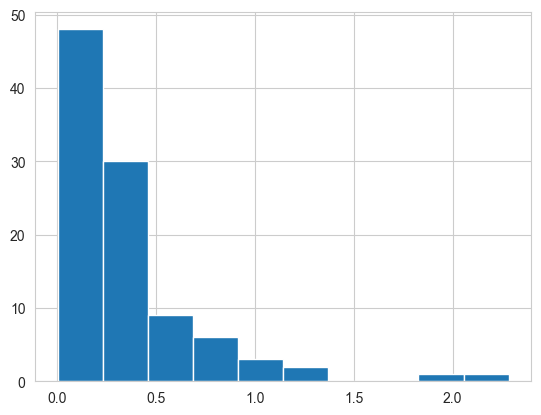

In [18]:
plt.hist(np.random.exponential(0.3, (100,1)))

In [19]:
output_max_samples = 2000
in_dim = 1 # We have a single descriptor

kernel_y = 64
cnn_layers = 3
latent_max_samples = output_max_samples + cnn_layers*kernel_y # We will add some padding to the latent space

latent_dim = 27 # This you can change
batch_size = sample_x.shape[0]
cnn_channels = 16

# Takes in the input descriptors and returns the output point cloud

desc2latent = nn.Sequential(
            # Input to latent space
            nn.ConvTranspose1d(in_dim, latent_dim//4, kernel_size=latent_max_samples//2, stride=1, padding=0, bias=True),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(latent_dim//4, latent_dim, kernel_size=latent_max_samples//2-1, stride=1, padding=0, bias=True),
            nn.LeakyReLU(0.2),
        )

# This is a good idea but difficult to implement with padding
# zx = torch.rand(batch_size, latent_max_samples, 1) # X is uniform
# zy = torch.rand(batch_size, latent_max_samples, 1) # Y is uniform
# # R is inverse exponential
# zr = torch.tensor(np.random.exponential(0.3, (batch_size, latent_max_samples, 1)), dtype=torch.float32)
# z = torch.cat([zx, zy, zr], dim=-1)

# Simple way
z = torch.rand(batch_size, latent_max_samples, latent_dim)

kernel_x = latent_dim // cnn_layers 

latent2pointcloud = nn.Sequential(
            nn.Conv2d(1, cnn_channels, kernel_size=(kernel_y+1, kernel_x), stride=1, padding=0, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(cnn_channels, cnn_channels, kernel_size=(kernel_y+1, kernel_x), stride=1, padding=0, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(cnn_channels, 1, kernel_size=(kernel_y+1, kernel_x), stride=1, padding=0, bias=False),
        )

print(r"X:", sample_x.shape)
print("Z:", z.shape)

x = sample_x
x = desc2latent(x)
print("mean:", x.mean(), x.min(), x.max())
x = x.transpose(-1,-2) 

print("Latent:", x.shape)
x = x + z
x = x.unsqueeze(1)

print("Latent random: ", x.shape)

x = latent2pointcloud(x)
x = x.squeeze(1)
print("Point cloud: ", x.shape)



# print("Latent reshaped:", desc2latent(sample_x_2d).reshape(batch_size, 1, -1, latent_dim).shape)
# print("Latent reshaped:", desc2latent(sample_x_2d).transpose(-1,-2).reshape(batch_size, 1, -1, latent_dim).shape)
# print("Output:", latent2pointcloud((desc2latent(sample_x_2d).reshape(batch_size, 1, -1, latent_dim))).shape)
# print(latent2pointcloud((desc2latent(sample_x_2d).transpose(-1,-2)*z)).shape)

# print(summary(latent2pointcloud,depth=1))
print(summary(desc2latent,depth=0))
print(summary(latent2pointcloud,depth=0))
# latent2pointcloud(desc2latent(sample_x)*z).transpose(-1,-2).shape


X: torch.Size([32, 1, 3])
Z: torch.Size([32, 2192, 27])
mean: tensor(0.0003, grad_fn=<MeanBackward0>) tensor(-0.0023, grad_fn=<MinBackward1>) tensor(0.0092, grad_fn=<MaxBackward1>)
Latent: torch.Size([32, 2192, 27])
Latent random:  torch.Size([32, 1, 2192, 27])
Point cloud:  torch.Size([32, 2000, 3])
Layer (type:depth-idx)                   Param #
Sequential                               183,999
Total params: 183,999
Trainable params: 183,999
Non-trainable params: 0
Layer (type:depth-idx)                   Param #
Sequential                               168,480
Total params: 168,480
Trainable params: 168,480
Non-trainable params: 0


In [20]:
from src.models.HardSphereGAN import HSGenerator


print(HSGenerator(output_max_samples=dataset.y.shape[1], latent_dim=27, in_dim=3)(sample_x).shape)

summary(
    HSGenerator(output_max_samples=dataset.y.shape[1], latent_dim=9, in_dim=3, cnn_channels=4), input_data=sample_x
    )


torch.Size([32, 2000, 3])


Layer (type:depth-idx)                   Output Shape              Param #
HSGenerator                              [32, 2000, 3]             --
├─Sequential: 1-1                        [32, 9, 2192]             --
│    └─ConvTranspose1d: 2-1              [32, 4, 1098]             4,388
│    └─ConvTranspose1d: 2-2              [32, 9, 2192]             39,429
├─Sequential: 1-2                        [32, 1, 2000, 3]          --
│    └─Conv2d: 2-3                       [32, 4, 2128, 7]          784
│    └─BatchNorm2d: 2-4                  [32, 4, 2128, 7]          8
│    └─LeakyReLU: 2-5                    [32, 4, 2128, 7]          --
│    └─Conv2d: 2-6                       [32, 4, 2064, 5]          3,124
│    └─BatchNorm2d: 2-7                  [32, 4, 2064, 5]          8
│    └─LeakyReLU: 2-8                    [32, 4, 2064, 5]          --
│    └─Conv2d: 2-9                       [32, 1, 2000, 3]          781
Total params: 48,522
Trainable params: 48,522
Non-trainable params: 0
Total

<Axes: >

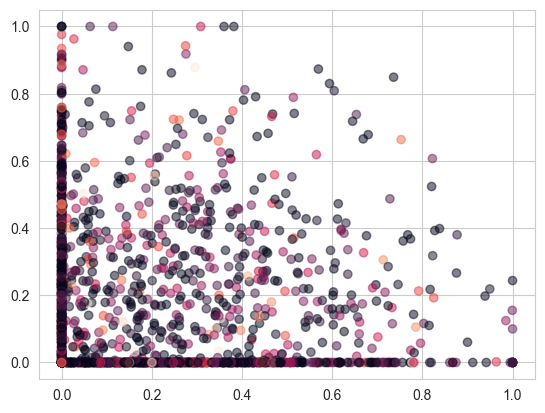

In [21]:
sample_pred_y = HSGenerator(output_max_samples=dataset.y.shape[1], latent_dim=27, in_dim=3)(sample_x).detach()

plot_pointcloud(sample_pred_y[0,:,:], plot_radius=False)

In [22]:
from src.models.HardSphereGAN import HSDiscriminator

print(sample_x.shape)
print(sample_y.shape)
HSDiscriminator(channels_img=1, features_d=4)(sample_y).shape

summary(HSDiscriminator(channels_img=1, features_d=32), input_data=sample_y, depth=2)

torch.Size([32, 1, 3])
torch.Size([32, 2000, 3])


Layer (type:depth-idx)                   Output Shape              Param #
HSDiscriminator                          [32, 1]                   --
├─Sequential: 1-1                        [32, 1]                   --
│    └─Conv2d: 2-1                       [32, 16, 969, 2]          2,064
│    └─LeakyReLU: 2-2                    [32, 16, 969, 2]          --
│    └─Sequential: 2-3                   [32, 32, 314, 3]          32,832
│    └─Sequential: 2-4                   [32, 32, 301, 4]          32,832
│    └─Conv2d: 2-5                       [32, 1, 298, 3]           257
│    └─Flatten: 2-6                      [32, 894]                 --
│    └─MaxPool1d: 2-7                    [32, 178]                 --
│    └─Linear: 2-8                       [32, 32]                  5,728
│    └─LeakyReLU: 2-9                    [32, 32]                  --
│    └─Linear: 2-10                      [32, 1]                   33
│    └─Sigmoid: 2-11                     [32, 1]                   --


In [85]:
# if detect_bad_gradients:
#             with autograd.detect_anomaly():
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels, weights)  # Compute RMSE from MSE
#                 loss.backward()
#         else:
#             outputs = model(inputs)
#             loss = criterion(outputs, labels, weights)  # Compute RMSE from MSE
#             loss.backward()
#         grad_norm = torch.nn.utils.clip_grad_norm_(
#             model.parameters(), 50
#         )  # Clip gradients

## Train the model

In [43]:
run_params = {
    "training":{
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "batch_size": 64,
        "epochs": 50,
        "early_stopping_patience": None,
        "log_image_frequency": 5,
        "optimizer_g": {
            "name": "AdamHD",
            "lr": 0.0002,
            "weight_decay": 1e-5,
            "hypergrad_lr": 1e-7
        },
        "optimizer_d": {
            "name": "AdamHD",
            "lr": 0.0002,
            "weight_decay": 1e-5,
            "hypergrad_lr": 1e-7
        },
    },
    "generator": {
        "output_max_samples": dataset.y.shape[1],
        "in_dim": 3,
        "latent_dim": 12,
        "cnn_channels": 24,
    },
    "discriminator": {
        "channels_img":1,
        "features_d": 8
    }
}

In [33]:
test_frac = 0.2

trainset, testset = torch.utils.data.random_split(dataset, [1-test_frac, test_frac])

In [ ]:
from src.models.HardSphereGAN import GAN


gan = GAN(trainset, testset, **run_params)

print(summary(gan.generator, input_data=sample_x, depth=2))
print(summary(gan.discriminator, input_data=sample_y, depth=2))


Layer (type:depth-idx)                   Output Shape              Param #
HSGenerator                              [32, 2000, 3]             --
├─Sequential: 1-1                        [32, 12, 2192]            --
│    └─ConvTranspose1d: 2-1              [32, 6, 1098]             6,582
│    └─ConvTranspose1d: 2-2              [32, 12, 2192]            78,852
├─Sequential: 1-2                        [32, 1, 2000, 3]          --
│    └─Conv2d: 2-3                       [32, 24, 2128, 9]         6,264
│    └─BatchNorm2d: 2-4                  [32, 24, 2128, 9]         48
│    └─LeakyReLU: 2-5                    [32, 24, 2128, 9]         --
│    └─Conv2d: 2-6                       [32, 24, 2064, 6]         149,784
│    └─BatchNorm2d: 2-7                  [32, 24, 2064, 6]         48
│    └─LeakyReLU: 2-8                    [32, 24, 2064, 6]         --
│    └─Conv2d: 2-9                       [32, 1, 2000, 3]          6,241
Total params: 247,819
Trainable params: 247,819
Non-trainable param

In [79]:
gan.train_n_epochs(2,batch_size=128, experiment_name="MLFlow test")

[autoreload of src.models.HardSphereGAN failed: Traceback (most recent call last):
  File "/Users/veikko/Documents/GitHub/hard-spheres/.venv/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/veikko/Documents/GitHub/hard-spheres/.venv/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/Users/veikko/Documents/GitHub/hard-spheres/src/models/HardSphereGAN.py", line 8, in <module>
    from matplotlib import pyplto as plt
ImportError: cannot import name 'pyplto' from 'matpl

Starting...
Time: 2024-06-20 23:26:23


  0%|          | 0/6 [00:15<?, ?it/s]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/veikko/Documents/GitHub/hard-spheres/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/q9/ztf8_qts26v_zgn8x6qhqd6h0000gn/T/ipykernel_863/2309347951.py", line 1, in <module>
    gan.train_n_epochs(2,batch_size=128, experiment_name="MLFlow test")
  File "/Users/veikko/Documents/GitHub/hard-spheres/src/models/HardSphereGAN.py", line 224, in train_n_epochs
    for epoch in range(epochs):
  File "/Users/veikko/Documents/GitHub/hard-spheres/src/models/HardSphereGAN.py", line 311, in _train_epoch
  File "/Users/veikko/Documents/GitHub/hard-spheres/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/Users/veikko/Documents/GitHub/hard-spheres/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1520, in _call_impl
    re

In [ ]:
    # # Log the model
    # model_info = mlflow.sklearn.log_model(
    #     sk_model=lr,
    #     artifact_path="iris_model",
    #     signature=signature,
    #     input_example=X_train,
    #     registered_model_name="tracking-quickstart",
    # )

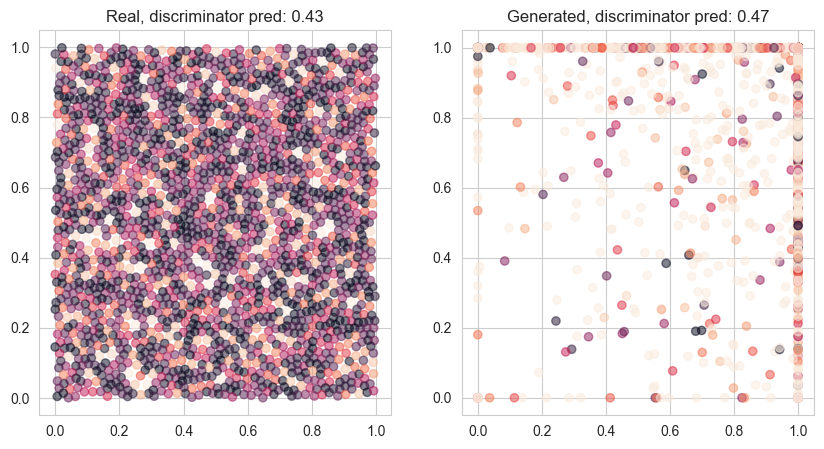

In [78]:
# Check on the created figures

plot_sample_figures(gan.generator, gan.discriminator, dataset, n=5, plot_radius=False)

In [ ]:
# Check physical feasibility of the generated point clouds

# Start with summing overlapping areas

def count_overlaps(xs, ys, rs):
    # Count the number of overlaps in the pointcloud
    # Overlapping areas are areas where the radius of a point is larger than the distance to the nearest point minus the radius of the nearest point

    # n_points = pointclouds.shape[0]
    # overlaps = 0

    # distances = torch.cdist(pointclouds, pointclouds)
    pass
    

   


# Check if the sum of overlapping areas is correct
# pointclouds = dataset[:][1]
# count_overlaps(pointclouds)


# Profile model performance for computational bottlenecks

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        generator(sample_x)

    # print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))


STAGE:2024-05-18 18:32:50 53521:4743870 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-05-18 18:32:50 53521:4743870 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-05-18 18:32:50 53521:4743870 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [ ]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))

--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                 model_inference        41.71%       5.928ms       100.00%      14.214ms      14.214ms             1  
               aten::convolution         0.27%      38.000us        30.12%       4.281ms       2.140ms             2  
              aten::_convolution        18.66%       2.652ms        29.85%       4.243ms       2.122ms             2  
          aten::conv_transpose1d         0.04%       5.000us        20.88%       2.968ms       2.968ms             1  
                     aten::randn         5.29%     752.000us        17.73%       2.520ms       2.520ms             1  
                   aten::normal_        12.40%  

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        discriminator(sample_y)

    # print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))


STAGE:2024-05-18 18:33:05 53521:4743870 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-05-18 18:33:05 53521:4743870 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-05-18 18:33:05 53521:4743870 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [ ]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference        26.75%       4.685ms       100.00%      17.513ms      17.513ms             1  
                     aten::conv2d         0.22%      39.000us        58.93%      10.321ms       2.064ms             5  
                aten::convolution         0.50%      88.000us        58.71%      10.282ms       2.056ms             5  
               aten::_convolution         0.36%      63.000us        58.21%      10.194ms       2.039ms             5  
         aten::mkldnn_convolution        57.36%      10.045ms        57.85%      10.131ms       2.026ms             5  
                 aten::leaky_relu       

### OPEN QUESTIONS

- What to do with the metadata?
- Class and radius are redundant. Is the real physical measure numerical or categorical / quantified? 

In [45]:
metadata.round(5).drop_duplicates()

,,N,L,A
experiment,sample,,,
phi-0.74,sample-245,2000,46.88709,1626.81571
phi-0.72,sample-245,2000,47.53384,1626.81571
phi-0.70,sample-245,2000,48.20812,1626.81571
